In [1]:
import sys
sys.path.append('/mnt/c/Users/Wayne/tvb/tvbtools/')
from tvbtools.signaltools import SignalToolkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy
my_layout = widgets.Layout()
plt.style.use('ggplot')
import os
import random
import seaborn as sns


In [2]:
node_names = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMp-R','mTEMp-L','mTEMp-R']
node_hemi = ['aCNG', 'mCNG','pCNG','HIP','PHG','AMY', 'sTEMp','mTEMp']
path = '/mnt/c/Users/Wayne/tvb/stat_data/Gc_Go.xlsx'
coData = pd.read_excel(path)
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
def bold_psd(grp, caseid):
    # import empirical functional connectivity
    # Here is the path of the mat file of the FC data
    pth = "/mnt/c/Users/Wayne/tvb/TS-4-Vik/"+ grp+'-TS/'+ caseid +"/ROISignals_"+ caseid +".mat"
    subject = SignalToolkit(filename=pth, fs=0.5)
    bold = subject.data_reader()
    df = pd.DataFrame.from_dict(bold.get("ROISignals"))
    df.columns = node_names
    dfd = pd.DataFrame()

    # for i in range(16):
    #     x, y = subject.psd(data=df.iloc[:,i], visual=False)
    #     _dfd = pd.Series(data=y,copy=False)
    #     dfd = pd.concat([dfd, _dfd], ignore_index = True, axis=1)
    # dfd.columns = node_names
    ladict = {}
    ladict['grp'] = grp
    ladict['caseid'] = caseid
    for index, n in enumerate(range(0,15,2)):
        faxis, dominant_left = subject.psd(data=df.iloc[:,n], sampling_interval=2, visual=False, xlim=0.25, fNQ = 512)
        faxis, dominant_right = subject.psd(data=df.iloc[:,n+1], sampling_interval=2, visual=False, xlim=0.25, fNQ = 512)
        la = (dominant_right[1:int(len(faxis)/2)] - dominant_left[1:int(len(faxis)/2)])/(dominant_left[1:int(len(faxis)/2)] + dominant_right[1:int(len(faxis)/2)])
        ladict[node_hemi[index]]=np.mean(la)
            
    ladict['overall'] = np.mean([ladict.get(n) for n in node_hemi if n not in ['pCNG']])
    # fig = plt.figure(figsize=(15,5))
    # axes = fig.add_subplot(111)
    # faxis, dominant_left = subject.psd(data=df.iloc[:,4], sampling_interval=2, visual=False, xlim=0.25, fNQ = 512, label="pcg_left")
    # faxis, dominant_right = subject.psd(data=df.iloc[:,5], sampling_interval=2, visual=False, xlim=0.25, fNQ = 512, label="pcg_right")
    # plt.legend()
    #return faxis[np.argmax(dominant_left)]*dominant_left[np.argmax(dominant_left)], faxis[np.argmax(dominant_right)]*dominant_right[np.argmax(dominant_right)]
    return ladict


    # dfd.plot.bar(figsize=(15,5))

    # dfd.to_excel(f"/mnt/c/Users/Wayne/tvb/psdres/psd_data/{grp}/{caseid}.xlsx")
    # axes = subject.panel()
    # axes.set_title(f"{grp}_{caseid}_limbic")
    # for i in range(16):
    #     subject.psd(data=df.iloc[:,i], visual=True, axes=axes, xlim=0.25, label =node_names[i], c=color[i])
    # plt.legend()
    # plt.savefig(f"/mnt/c/Users/wayne/tvb/psdres/limbic/{grp}_{caseid}.png", dpi=300)
    
    # axes = subject.panel()
    # axes.set_title(f"{grp}_{caseid}_pcg")
    # for i in [4,5]:
    #     subject.psd(data=df.iloc[:,i], visual=True, axes=axes, xlim=0.25, label =node_names[i], c=color[i])
    # plt.legend()
    # plt.savefig(f"/mnt/c/Users/wayne/tvb/psdres/pcg/{grp}_{caseid}.png", dpi=300)


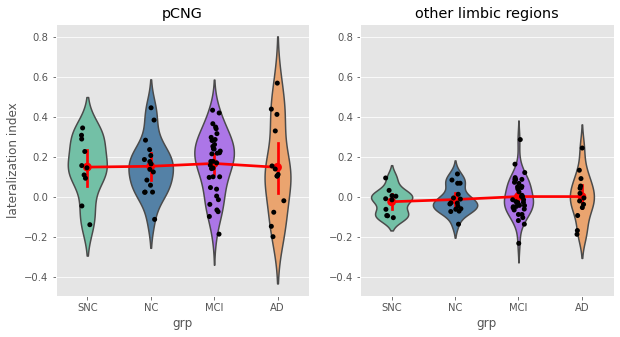

In [6]:
# dd = bold_psd("SNC","4481A")

dfdict = pd.DataFrame()
for grp, caseid in zip(coData.groups,coData.caseid):
    dd = bold_psd(grp,caseid)
    dfdict = pd.concat([dfdict, pd.DataFrame.from_dict([dd])], ignore_index=True)


def psvplot(x,y, axes):
    sns.violinplot(x=x, y=y, data=dfdict, palette=colors, inner = None, width=0.7, bw=0.5, ax=axes)
    sns.stripplot( data=dfdict, x=x, y=y, color='black', label="right", ax = axes)
    sns.pointplot(x=x, y=y, data=dfdict, estimator=np.mean, color = 'red', ax=axes)

fig = plt.figure(figsize=(10,5))
#plt.title("lateralization comparison between pcg and other limbic regions")
axes = fig.add_subplot(121)
x = 'grp'
y = 'pCNG'
psvplot(x, y, axes)
axes.set_ylabel("lateralization index")
#axes.set_ylim(0.1,0.7)
axes.set_title("pCNG")

x = 'grp'
y = 'overall'
axes2 = fig.add_subplot(122)
psvplot(x, y, axes2)
axes2.sharey(axes)
axes2.set(ylabel=None)
axes2.set_title("other limbic regions")

# axes.set_ylabel("lateralization index")
# axes.set_ylim(0.1,0.8)
# axes.set_title("violin plot of lateralization in pCNG regions")
plt.savefig("/mnt/c/Users/Wayne/tvb/psdres/la_others_raw.png", dpi=300)

In [4]:
# %matplotlib widget
# bold_psd("SNC","4481A")
from numpy import mean

def legend_without_duplicate_labels(figure):
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    figure.legend(by_label.values(), by_label.keys())

df = pd.DataFrame()
for grp, caseid in zip(coData.groups,coData.caseid):
    x,y = bold_psd(grp,caseid)
    df = pd.concat([df, pd.DataFrame.from_records([{'grp':grp, "casied":caseid, "dominant_left":x, "dominant_right":y, "dominant_both":np.mean([x,y])}])], ignore_index=True)

fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(111)
sns.stripplot(ax = axes, data=df, x='grp', y='dominant_left', alpha = 1.0, color='red', label="left")
sns.stripplot(ax = axes, data=df, x='grp', y='dominant_right', color='black', label="right")
legend_without_duplicate_labels(plt)
# axes.set_ylabel("dominant frequency")
# axes.set_title("pcg")
# # plt.savefig("/mnt/c/Users/Wayne/tvb/dominant_freq.png", dpi=300)
# sns.stripplot(ax = axes, data=df, x='grp', y='dominant_both', alpha = 0.5, color='black', label="both")
# sns.violinplot(x="grp", y="dominant_both", data=df, palette=colors, ax=axes, inner = None, width=0.7, bw=0.5)
sns.pointplot(x="grp", y="dominant_left", data=df, estimator=mean, color='red')
sns.pointplot(x="grp", y="dominant_right", data=df, estimator=mean, color = 'black')
#sns.kdeplot(data=df, x="dominant_both", hue="grp", cut=0, fill=True, common_norm=False, alpha=0.7, bw_adjust=.1, ax=axes, palette=colors)
axes.set_title("violin plot of dominant freq bothside")
plt.savefig("/mnt/c/Users/Wayne/tvb/psdres/dominant_freq.png", dpi=300)

ValueError: too many values to unpack (expected 2)

In [ ]:
# %matplotlib widget
# x = [10,120,130,120,120,100,123,456,78,89]

# subject= SignalToolkit()
# x = x-np.mean(x)
# subject.psd(data=x, sampling_interval=1/10, visual=True, xlim=5, fNQ = 512)